## Set Up Dependencies and Data


In [1]:
import random

import alifedata_phyloinformatics_convert as apc
from Bio import Phylo as BioPhylo
from hstrat import hstrat
from hsurf import hsurf
import joblib
import more_itertools as mit
import pandas as pd
from teeplot import teeplot as tp

from pylib._draw_biopython_tree import draw_biopython_tree
from pylib._make_hamming_distance_matrix import make_hamming_distance_matrix
from pylib._val_to_color import val_to_color


In [2]:
df = pd.read_csv("https://osf.io/x3h9c/download")


## Reproducibility


In [3]:
%load_ext watermark
%watermark -iwbmuvg -iv


Last updated: 2024-04-15T02:19:31.479324+00:00

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.20.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.5.0-1017-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

Git hash: 0d9418024cbedf6b128ddd11a123a085f9e4633b

Git branch: HEAD

teeplot                           : 1.0.1
hstrat                            : 1.11.4
more_itertools                    : 10.2.0
joblib                            : 1.3.2
Bio                               : 1.83
pandas                            : 1.5.3
alifedata_phyloinformatics_convert: 0.16.2
hsurf                             : 0.3.0

Watermark: 2.4.3



In [4]:
df.head()


,bitfield,genomeFlavor,globalSeed,nCycle,replicate
0,B89B1A00CB585BA5CF22E507,genome_hsurftiltedsticky_tagged,1,25,e4ea2071-8228-42de-af8c-879cedff9ba7
1,8AA21A004D16A4AAE8CA9D5A,genome_hsurftiltedsticky_tagged,1,25,e4ea2071-8228-42de-af8c-879cedff9ba7
2,78961A0082A13567A6F7C98C,genome_hsurftiltedsticky_tagged,1,25,e4ea2071-8228-42de-af8c-879cedff9ba7
3,5C571A00D0D36078075BCB53,genome_hsurftiltedsticky_tagged,1,25,e4ea2071-8228-42de-af8c-879cedff9ba7
4,BE17170002E36EEC007886B6,genome_hsurftiltedsticky_tagged,1,25,e4ea2071-8228-42de-af8c-879cedff9ba7


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   bitfield      36 non-null     object
 1   genomeFlavor  36 non-null     object
 2   globalSeed    36 non-null     int64 
 3   nCycle        36 non-null     int64 
 4   replicate     36 non-null     object
dtypes: int64(2), object(3)
memory usage: 1.5+ KB


In [6]:
df.describe()


,globalSeed,nCycle
count,36.00,36.000000
mean,2.75,106.250000
std,1.50,88.514527
min,1.00,25.000000
25%,1.75,43.750000
50%,2.50,75.000000
75%,3.50,137.500000
max,5.00,250.000000


In [7]:
joblib.hash(df)


'a239a51bb0180fd22f6ec984249b6400'

## Data Prep


In [8]:
exclude_leading = 16

df["bitfield"] = df["bitfield"].apply(lambda x: int(x, 16))
df["bitfield value bitlengths"] = df["bitfield"].apply(int.bit_length)
df["bitfield wordlengths"] = (df["bitfield value bitlengths"] + 31) // 32
assert mit.one(df["bitfield wordlengths"].unique()) == 3
df["bitfield bitlengths"] = df["bitfield wordlengths"] * 32
df["surface bitlengths"] = df["bitfield bitlengths"] - exclude_leading
df["surface bytelengths"] = df["surface bitlengths"] // 8

df


,bitfield,genomeFlavor,globalSeed,nCycle,replicate,bitfield value bitlengths,bitfield wordlengths,bitfield bitlengths,surface bitlengths,surface bytelengths
0,57132748105348876933567538439,genome_hsurftiltedsticky_tagged,1,25,e4ea2071-8228-42de-af8c-879cedff9ba7,96,3,96,80,10
1,42904900125206552265462816090,genome_hsurftiltedsticky_tagged,1,25,e4ea2071-8228-42de-af8c-879cedff9ba7,96,3,96,80,10
2,37319662842445020649435416972,genome_hsurftiltedsticky_tagged,1,25,e4ea2071-8228-42de-af8c-879cedff9ba7,95,3,96,80,10
3,28577920246446250520265608019,genome_hsurftiltedsticky_tagged,1,25,e4ea2071-8228-42de-af8c-879cedff9ba7,95,3,96,80,10
4,58830065774543937498254968502,genome_hsurftiltedsticky_tagged,1,25,e4ea2071-8228-42de-af8c-879cedff9ba7,96,3,96,80,10
5,10689392945463516266895595600,genome_hsurftiltedsticky_tagged,1,25,e4ea2071-8228-42de-af8c-879cedff9ba7,94,3,96,80,10
6,3909788886936383844204991948,genome_hsurftiltedsticky_tagged,1,25,e4ea2071-8228-42de-af8c-879cedff9ba7,92,3,96,80,10
7,34114795778211063320100699335,genome_hsurftiltedsticky_tagged,1,25,e4ea2071-8228-42de-af8c-879cedff9ba7,95,3,96,80,10
8,28987727207719297050051790413,genome_hsurftiltedsticky_tagged,1,25,e4ea2071-8228-42de-af8c-879cedff9ba7,95,3,96,80,10
9,54173387423123574533666229324,genome_hsurftiltedsticky_tagged,2,50,3d55af5f-7714-45da-9276-e860f46b4d94,96,3,96,80,10


In [9]:
bitfield_bitlength = int(mit.one(df["bitfield bitlengths"].unique()))
surface_mask = (  # mask off leading 16 bit
    1 << (bitfield_bitlength - exclude_leading)
) - 1
assert surface_mask.bit_count() == bitfield_bitlength - exclude_leading
df["bitfield surface"] = df["bitfield"].values & surface_mask

df


,bitfield,genomeFlavor,globalSeed,nCycle,replicate,bitfield value bitlengths,bitfield wordlengths,bitfield bitlengths,surface bitlengths,surface bytelengths,bitfield surface
0,57132748105348876933567538439,genome_hsurftiltedsticky_tagged,1,25,e4ea2071-8228-42de-af8c-879cedff9ba7,96,3,96,80,10,122796181116766128366855
1,42904900125206552265462816090,genome_hsurftiltedsticky_tagged,1,25,e4ea2071-8228-42de-af8c-879cedff9ba7,96,3,96,80,10,122787083362855140629850
2,37319662842445020649435416972,genome_hsurftiltedsticky_tagged,1,25,e4ea2071-8228-42de-af8c-879cedff9ba7,95,3,96,80,10,122790941418026255763852
3,28577920246446250520265608019,genome_hsurftiltedsticky_tagged,1,25,e4ea2071-8228-42de-af8c-879cedff9ba7,95,3,96,80,10,122796576031459386313555
4,58830065774543937498254968502,genome_hsurftiltedsticky_tagged,1,25,e4ea2071-8228-42de-af8c-879cedff9ba7,96,3,96,80,10,108614637237969528325814
5,10689392945463516266895595600,genome_hsurftiltedsticky_tagged,1,25,e4ea2071-8228-42de-af8c-879cedff9ba7,94,3,96,80,10,70848430965104143587408
6,3909788886936383844204991948,genome_hsurftiltedsticky_tagged,1,25,e4ea2071-8228-42de-af8c-879cedff9ba7,92,3,96,80,10,122786302673093205218764
7,34114795778211063320100699335,genome_hsurftiltedsticky_tagged,1,25,e4ea2071-8228-42de-af8c-879cedff9ba7,95,3,96,80,10,118074505842639067118791
8,28987727207719297050051790413,genome_hsurftiltedsticky_tagged,1,25,e4ea2071-8228-42de-af8c-879cedff9ba7,95,3,96,80,10,103904999718698947102285
9,54173387423123574533666229324,genome_hsurftiltedsticky_tagged,2,50,3d55af5f-7714-45da-9276-e860f46b4d94,96,3,96,80,10,212520372426585907776588


In [10]:
df["bitfield tag"] = df["bitfield"].values >> (
    bitfield_bitlength - exclude_leading
)

df


,bitfield,genomeFlavor,globalSeed,nCycle,replicate,bitfield value bitlengths,bitfield wordlengths,bitfield bitlengths,surface bitlengths,surface bytelengths,bitfield surface,bitfield tag
0,57132748105348876933567538439,genome_hsurftiltedsticky_tagged,1,25,e4ea2071-8228-42de-af8c-879cedff9ba7,96,3,96,80,10,122796181116766128366855,47259
1,42904900125206552265462816090,genome_hsurftiltedsticky_tagged,1,25,e4ea2071-8228-42de-af8c-879cedff9ba7,96,3,96,80,10,122787083362855140629850,35490
2,37319662842445020649435416972,genome_hsurftiltedsticky_tagged,1,25,e4ea2071-8228-42de-af8c-879cedff9ba7,95,3,96,80,10,122790941418026255763852,30870
3,28577920246446250520265608019,genome_hsurftiltedsticky_tagged,1,25,e4ea2071-8228-42de-af8c-879cedff9ba7,95,3,96,80,10,122796576031459386313555,23639
4,58830065774543937498254968502,genome_hsurftiltedsticky_tagged,1,25,e4ea2071-8228-42de-af8c-879cedff9ba7,96,3,96,80,10,108614637237969528325814,48663
5,10689392945463516266895595600,genome_hsurftiltedsticky_tagged,1,25,e4ea2071-8228-42de-af8c-879cedff9ba7,94,3,96,80,10,70848430965104143587408,8842
6,3909788886936383844204991948,genome_hsurftiltedsticky_tagged,1,25,e4ea2071-8228-42de-af8c-879cedff9ba7,92,3,96,80,10,122786302673093205218764,3234
7,34114795778211063320100699335,genome_hsurftiltedsticky_tagged,1,25,e4ea2071-8228-42de-af8c-879cedff9ba7,95,3,96,80,10,118074505842639067118791,28219
8,28987727207719297050051790413,genome_hsurftiltedsticky_tagged,1,25,e4ea2071-8228-42de-af8c-879cedff9ba7,95,3,96,80,10,103904999718698947102285,23978
9,54173387423123574533666229324,genome_hsurftiltedsticky_tagged,2,50,3d55af5f-7714-45da-9276-e860f46b4d94,96,3,96,80,10,212520372426585907776588,44811


In [11]:
df = df.groupby("replicate", group_keys=False).apply(
    lambda group: group.assign(**{
        "taxon name": (
            group.groupby("replicate").cumcount().astype(str) + "-" + group["bitfield tag"].apply(hex)
        )
    })
)
df


,bitfield,genomeFlavor,globalSeed,nCycle,replicate,bitfield value bitlengths,bitfield wordlengths,bitfield bitlengths,surface bitlengths,surface bytelengths,bitfield surface,bitfield tag,taxon name
0,57132748105348876933567538439,genome_hsurftiltedsticky_tagged,1,25,e4ea2071-8228-42de-af8c-879cedff9ba7,96,3,96,80,10,122796181116766128366855,47259,0-0xb89b
1,42904900125206552265462816090,genome_hsurftiltedsticky_tagged,1,25,e4ea2071-8228-42de-af8c-879cedff9ba7,96,3,96,80,10,122787083362855140629850,35490,1-0x8aa2
2,37319662842445020649435416972,genome_hsurftiltedsticky_tagged,1,25,e4ea2071-8228-42de-af8c-879cedff9ba7,95,3,96,80,10,122790941418026255763852,30870,2-0x7896
3,28577920246446250520265608019,genome_hsurftiltedsticky_tagged,1,25,e4ea2071-8228-42de-af8c-879cedff9ba7,95,3,96,80,10,122796576031459386313555,23639,3-0x5c57
4,58830065774543937498254968502,genome_hsurftiltedsticky_tagged,1,25,e4ea2071-8228-42de-af8c-879cedff9ba7,96,3,96,80,10,108614637237969528325814,48663,4-0xbe17
5,10689392945463516266895595600,genome_hsurftiltedsticky_tagged,1,25,e4ea2071-8228-42de-af8c-879cedff9ba7,94,3,96,80,10,70848430965104143587408,8842,5-0x228a
6,3909788886936383844204991948,genome_hsurftiltedsticky_tagged,1,25,e4ea2071-8228-42de-af8c-879cedff9ba7,92,3,96,80,10,122786302673093205218764,3234,6-0xca2
7,34114795778211063320100699335,genome_hsurftiltedsticky_tagged,1,25,e4ea2071-8228-42de-af8c-879cedff9ba7,95,3,96,80,10,118074505842639067118791,28219,7-0x6e3b
8,28987727207719297050051790413,genome_hsurftiltedsticky_tagged,1,25,e4ea2071-8228-42de-af8c-879cedff9ba7,95,3,96,80,10,103904999718698947102285,23978,8-0x5daa
9,54173387423123574533666229324,genome_hsurftiltedsticky_tagged,2,50,3d55af5f-7714-45da-9276-e860f46b4d94,96,3,96,80,10,212520372426585907776588,44811,0-0xaf0b


In [12]:
df.dtypes


bitfield                     object
genomeFlavor                 object
globalSeed                    int64
nCycle                        int64
replicate                    object
bitfield value bitlengths     int64
bitfield wordlengths          int64
bitfield bitlengths           int64
surface bitlengths            int64
surface bytelengths           int64
bitfield surface             object
bitfield tag                 object
taxon name                   object
dtype: object

## Deserialize Columns


In [13]:
# import hsurf
# hsurf.__version__
from hsurf import hsurf


In [14]:
surface_bytelength = int(mit.one(df["surface bytelengths"].unique()))
print(f"{surface_bytelength=}")
site_selection_algo = hsurf.tilted_sticky_algo
differentia_bitwidth = 1

print(df["bitfield surface"])
df["hstrat_columns"] = [
    hsurf.col_from_surf_int(
        value=value,
        differentia_bit_width=differentia_bitwidth,
        site_selection_algo=site_selection_algo,
        differentiae_byte_bit_order="little",
        num_strata_deposited_byte_width=2,  # u16
        num_strata_deposited_byte_order="little",
        value_byte_width=surface_bytelength,
    )
    for value in df["bitfield surface"].values
]


surface_bytelength=10
0      122796181116766128366855
1      122787083362855140629850
2      122790941418026255763852
3      122796576031459386313555
4      108614637237969528325814
5       70848430965104143587408
6      122786302673093205218764
7      118074505842639067118791
8      103904999718698947102285
9      212520372426585907776588
10     212522017725534166077132
11     240856044588844338755267
12     221968314081243525297938
13     236131767777012604949632
14     212520313671068879653067
15     221964686342239538074756
16     240844697820226158029232
17     217232882294455454605712
18     368352109321290527813325
19     458083063393596692052221
20     443915964507937709832409
21     448629306841369499197648
22     406132492581695899219600
23     439195965524721783740122
24     448640908961993612880030
25     410854564775377842967828
26     434473845751537734544570
27    1123941654416833653790549
28    1015319499912270073870138
29     982263359407705151302550
30    108143053908

In [15]:
for col in df["hstrat_columns"]:
    print(col.GetNumStrataDeposited())


26
26
26
26
23
15
26
25
22
45
45
51
47
50
45
47
51
46
78
97
94
95
86
93
95
87
92
238
215
208
229
234
201
223
234
219


## Ascii Reconstructed Tree


In [16]:
for names, group in df.groupby("replicate"):
    tree_df = hstrat.build_tree(
        group["hstrat_columns"].values,
        hstrat.__version__,
        taxon_labels=group["taxon name"].values,
        force_common_ancestry=True,
    )
    print(apc.RosettaTree(tree_df).as_dendropy.as_ascii_plot(plot_metric="length"))


                                      /------------------------- 6-0x82c8      
/-------------------------------------+                                        
+                                     \----------------------------- 4-0x82c8  
|                                                                              
|------------------------------------------------------------ 0-0xaf0b         
|                                                                              
|                              /------------------------------ 8-0x55cf        
+     /------------------------+                                               
|  /--+                        \-------------------------------------- 7-0x55cf
|  |  |                                                                        
|--+  \------------------------------------------------------ 1-0x97c0         
|  |                                                                           
+  \------------------------------------

                                                           /-------- 4-0x82dd  
                          /--------------------------------+                   
             /------------+                                \-------- 7-0x82dd  
             |            |                                                    
             |            \-------------------------------------- 6-0x82dd     
/------------+                                                                 
|            |                            /-------------------- 1-0xebe0       
|            |                    /-------+                                    
|            |                    |       \--------------------- 8-0xebe0      
|            \--------------------+                                            
+                                 |       /---------------- 5-0xebe0           
|                                 \-------+                                    
|                                       

    /--------------------------------------------------- 0-0x51fc              
/---+                                                                          
|   \--------------------------------------------------------- 7-0x3738        
+                                                                              
|                     /-------------------------------------- 4-0x7d9          
|                    /+                                                        
|--------------------+\--------------------------------------------- 3-0x7d9   
|                    |                                                         
+                    \--------------------------------------------- 5-0x7d9    
|                                                                              
|                                                    /------------ 8-0x722b    
|----------------------------------------------------+                         
|                                       

       /------------------------------- 5-0x228a                               
 /-----+                                                                       
/+     \-------------------------------------------------------------- 0-0xb89b
||                                                                             
+\-------------------------------------------------------- 8-0x5daa            
|                                                                              
|--------------------------------------------------------------------- 1-0x8aa2
|                                                                              
+      /----------------------------------------------------- 4-0xbe17         
|/-----+                                                                       
|+     \-------------------------------------------------------------- 6-0xca2 
||                                                                             
+\--------------------------------------

In [17]:
tree_df["name"] = tree_df["taxon_label"]


## Plotted Reconstructed Tree


In [18]:
salt = "7"  # manually chosen for nice generated color


# adapted from https://github.com/mmore500/hstrat-recomb-concept/blob/b71d36216f1d2990343b6435240d8c193a82690b/pylib/tree/color_biopython_tree.py
def color_biopython_tree(tree: BioPhylo.BaseTree) -> None:
    """Recursively color tree"""
    terminals = [x.name.split("-")[1] for x in tree.get_terminals()]
    if len(set(terminals)) != 1:
        tree.color = (220, 220, 220)
    else:
        tree.color = val_to_color(mit.one(set(terminals)) + salt)

    for clade in tree.clades:
        color_biopython_tree(clade)


6-0x82c8
teeplots/genome=hsurftiltedsticky_tagged+replicate=3d55af5f-7714-45da-9276-e860f46b4d94+viz=draw-biopython-tree+ext=.pdf


teeplots/genome=hsurftiltedsticky_tagged+replicate=3d55af5f-7714-45da-9276-e860f46b4d94+viz=draw-biopython-tree+ext=.png


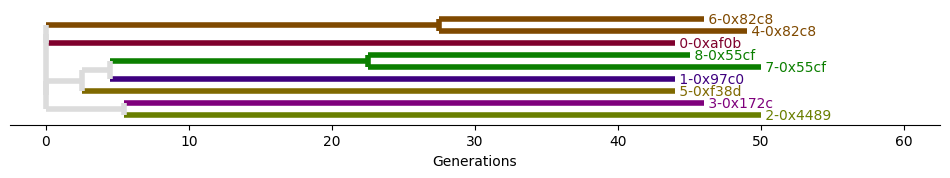

4-0x82dd
teeplots/genome=hsurftiltedsticky_tagged+replicate=42dbcbb3-b803-41a4-9285-4a450bfad6ed+viz=draw-biopython-tree+ext=.pdf
teeplots/genome=hsurftiltedsticky_tagged+replicate=42dbcbb3-b803-41a4-9285-4a450bfad6ed+viz=draw-biopython-tree+ext=.png


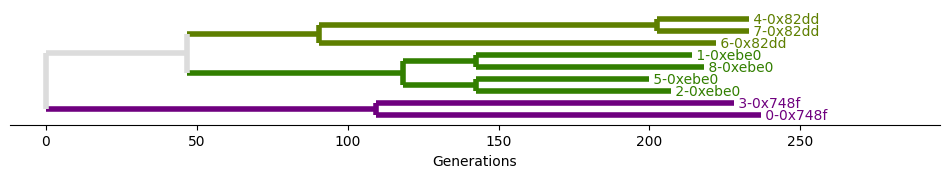

0-0x51fc
teeplots/genome=hsurftiltedsticky_tagged+replicate=932aa302-becb-47e8-9712-7f550b02364c+viz=draw-biopython-tree+ext=.pdf
teeplots/genome=hsurftiltedsticky_tagged+replicate=932aa302-becb-47e8-9712-7f550b02364c+viz=draw-biopython-tree+ext=.png


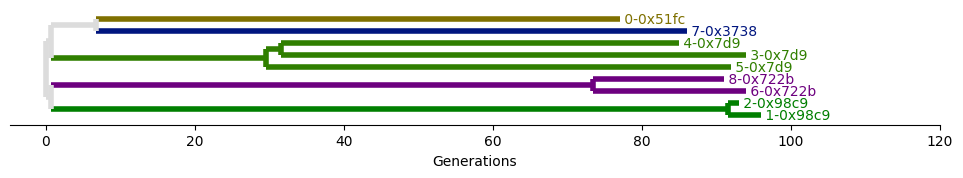

5-0x228a
teeplots/genome=hsurftiltedsticky_tagged+replicate=e4ea2071-8228-42de-af8c-879cedff9ba7+viz=draw-biopython-tree+ext=.pdf


teeplots/genome=hsurftiltedsticky_tagged+replicate=e4ea2071-8228-42de-af8c-879cedff9ba7+viz=draw-biopython-tree+ext=.png


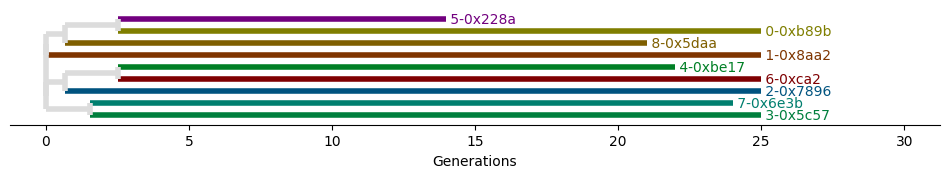

In [19]:
for names, group in df.groupby("replicate"):
    tree_df = hstrat.build_tree(
        group["hstrat_columns"].values,
        hstrat.__version__,
        taxon_labels=group["taxon name"].values,
        force_common_ancestry=True,
    )
    tree_df["name"] = tree_df["taxon_label"]

    biopy_tree = apc.RosettaTree(tree_df).as_biopython
    print(biopy_tree.get_terminals()[0].name)
    color_biopython_tree(biopy_tree.root)

    tp.tee(
        draw_biopython_tree,
        biopy_tree,
        fig_size=(12, 1.5),
        teeplot_outattrs={
            "genome": "hsurftiltedsticky_tagged",
            "replicate": group["replicate"].values[0],
        },
    )
